# Intro

The main question was if:

On the population:
 - (1) the dimensionality really changes over session?
 - (2) if it does, isn't it an artefact of TOT effect?
- (3) can it be explained by any behavioral variables?

on the single unit level:
- somehow relate CV or LvR to D?

---
# Setup

In [1]:
# @imports
import sys
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import pickle

# plot venn diagram of the significant units of model 'no cmw short history' and 'cmw short history'

from popy.io_tools import load_metadata, load_neural_data, load_behavior
from popy.neural_data_tools import *
from popy.behavior_data_tools import *
from popy.plotting.plotting_tools import plot_keypoints
from popy.plotting.plot_behavior import show_target_selection
from popy.decoding.population_decoders import build_dataset

import popy.config as cfg

In [20]:
# @plotting functions
def plot_dimensionality(dims, ax=None):
    # plot dimensionality
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    line1, = ax.plot(dims['start_trial'], dims['complexity_mcc'], label='MCC', color='grey')
    line2, = ax.plot(dims['start_trial'], dims['complexity_lpfc'], label='LPFC', color='tab:blue')

    ax.set_xlabel('Trial')
    ax.set_ylabel('Complexity')

    if ax is None:
        plt.show()
    else:
        return ax, [line1, line2]

def plot_dimensionality_with_dims(dims, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    # plot residuals
    ax_ = ax.twinx()
    line3, = ax_.plot(dims['start_trial'], dims['residuals'], label='residuals', color='tab:red', alpha=0.5)

    ax_.set_ylabel('Residuals')

    ax.spines['top'].set_visible(False)
    ax_.spines['top'].set_visible(False)

    if title is not None:
        ax.set_title(title)
    
    ax, lines = plot_dimensionality(dims, ax=ax)

    # Combine the handles and labels from both axes
    lines.append(line3)
    labels = [line.get_label() for line in lines]

    # Create a shared legend
    ax.legend(lines, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    
    
def plot_scores(res_pd):
    scores_mcc, scores_lpfc = res_pd['score_mcc'].values, res_pd['score_lpfc'].values

    # plot distributions
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    x_lim_min = min(min(scores_mcc), min(scores_lpfc)) -10
    x_lim_max = 5
    bins = np.linspace(x_lim_min, x_lim_max, 30)

    ax.hist(scores_mcc, bins=bins, alpha=0.5, label='MCC')
    ax.hist(scores_lpfc, bins=bins, alpha=0.5, label='LPFC')

    ax.axvline(0, color='red', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(x_lim_min, x_lim_max)

    ax.set_title(f'# sessions with R2 > 0: {np.sum((scores_mcc > 0) & (scores_lpfc > 0))}')
    ax.set_xlabel('R2 (cross validated)')
    ax.set_ylabel('# of sessions')

    ax.legend()

    plt.show()

In [3]:
# @helper functions
def load_data_custom(monkey, session, user_msg=False):
    neural_data = load_neural_data(monkey, session)
    neural_data = add_firing_rates(neural_data)

    # cleaning the data
    neural_data = remove_trunctuated_neurons(neural_data, print_usr_msg=user_msg, mode='remove', delay_limit=20)
    '''neural_data = remove_low_fr_neurons(neural_data, print_usr_msg=user_msg)
    neural_data = remove_low_varance_neurons(neural_data, print_usr_msg=user_msg, var_limit=1)
    neural_data = remove_drift_neurons(neural_data, print_usr_msg=user_msg)'''

    return neural_data

def load_dataset_custom(monkey, session, user_msg=False):
    neural_data = load_neural_data(monkey, session, return_dataset_format=True)
    neural_data = add_firing_rates(neural_data)

    # cleaning the data
    neural_data = remove_trunctuated_neurons(neural_data, print_usr_msg=user_msg, mode='remove', delay_limit=20)
    '''neural_data = remove_low_fr_neurons(neural_data, print_usr_msg=user_msg)
    neural_data = remove_low_varance_neurons(neural_data, print_usr_msg=user_msg, var_limit=1)
    neural_data = remove_drift_neurons(neural_data, print_usr_msg=user_msg)'''

    # add cv
    #neural_data = add_CV(neural_data, epochs='full_only')

    behav = load_behavior(monkey, session)
    behav = drop_time_fields(behav)
    behav = add_value_function(behav, monkey=monkey)

    neural_dataset, _ = build_dataset(neural_data, behav, n_extra_trials=0)

    return neural_dataset

# get dimensionality of session
def cv_explains_dim(dims, cvs):
    '''
    Check if the cross validated firing rates explain the dimensionality of the neural data.
    '''

    # prepare data: remove nans from cvs
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    cvs = imputer.fit_transform(cvs)

    # cross validate
    clf = LinearRegression()
    score = cross_val_score(clf, cvs, dims, cv=10).mean()

    return score

def get_dimensionality(X):
    '''
    Calculate the dimensionality of the neural data as the ratio of the sum of the eigenvalues squared to the sum of the eigenvalues:
    D = (sum(eigenvalues)^2) / sum(eigenvalues^2)
    '''

    X = X.T  # samples x features
    
    # normalize the data (z-score)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    pca = PCA()  # do pca
    pca.fit(X)
    
    eigenvalues = pca.explained_variance_
    numerator = np.sum(eigenvalues) ** 2
    denominator = np.sum(eigenvalues ** 2)
    return numerator/denominator  #dimensionality (edited) 

# plot change of dimensionality over 40 trial sliding window
def measure_dimensionality(neural_data, wil_len=40, skip_len=1):
    '''
    Measure the dimensionality (or complexity) of the neural data over a sliding window of trials.

    The dimensionality is calculated as the ratio of the sum of the eigenvalues squared to the sum of the eigenvalues:
    D = (sum(eigenvalues)^2) / sum(eigenvalues^2)

    The complexity is calculated as the dimensionality divided by the number of neurons:
    C = D / n_neurons

    '''
    # get trial ids
    trial_ids = np.unique(neural_data.trial_id)
    n_trials = len(trial_ids)

    # initialize result containers
    res = []

    # get dimensionality for a given window, sliding over trials
    for i in range(0, n_trials-wil_len, skip_len):
        trial_id = trial_ids[i]  # start id of the window
        trials = np.arange(trial_id, trial_id + wil_len)  # trials in the window

        # get neural data for the window
        neural_data_temp = neural_data.sel(time=neural_data.trial_id.isin(trials))  # get the window
        neural_data_temp = add_CV(neural_data_temp, epochs='full_only')  # add cv WHY????

        # get dimensionality for MCC and LPFC
        neural_data_temp_mcc = neural_data_temp.sel(unit=neural_data_temp.unit[neural_data_temp.area == 'MCC'])
        neural_data_temp_lpfc = neural_data_temp.sel(unit=neural_data_temp.unit[neural_data_temp.area == 'LPFC'])

        # get dimensionality
        dim_mcc = get_dimensionality(neural_data_temp_mcc.firing_rates.values)
        dim_lpfc = get_dimensionality(neural_data_temp_lpfc.firing_rates.values)

        # get complexity
        complexity_mcc = dim_mcc / len(neural_data_temp_mcc.unit)   
        complexity_lpfc = dim_lpfc / len(neural_data_temp_lpfc.unit)

        # get CV
        cv_mcc = neural_data_temp_mcc.CV_full.values
        cv_lpfc = neural_data_temp_lpfc.CV_full.values
        
        # store the results
        res.append({'start_trial': trial_id, 
                    'dim_mcc': dim_mcc,
                    'dim_lpfc': dim_lpfc,
                    'complexity_mcc': complexity_mcc, 
                    'complexity_lpfc': complexity_lpfc, 
                    'cv_mcc': cv_mcc, 
                    'cv_lpfc': cv_lpfc})

    return pd.DataFrame(res)

---
# Section 1: Dimensionality

In [4]:
# data loading and processing
session_metadata = load_metadata()
session_metadata = session_metadata[session_metadata['block_len_valid'] == True]

In [5]:
res = []
for monkey, session in session_metadata[['monkey', 'session']].values:
    try:
        #print(monkey, session)

        # load data
        neural_data = load_data_custom(monkey, session, user_msg=False)

        # get dimensionality, complexity and cv
        dims = measure_dimensionality(neural_data, wil_len=40, skip_len=1)

        # CV explains dimensionality?
        score_mcc = cv_explains_dim(dims=dims['dim_mcc'].values, cvs=np.stack(dims['cv_mcc'].values))
        score_lpfc = cv_explains_dim(dims=dims['dim_lpfc'].values, cvs=np.stack(dims['cv_lpfc'].values))

        # save scores
        res.append({'monkey': monkey, 'session': session,
                    'mean_complexity_mcc': np.mean(dims['complexity_mcc'].values),
                    'mean_complexity_lpfc': np.mean(dims['complexity_lpfc'].values),
                    'score_mcc': score_mcc,
                    'score_lpfc': score_lpfc})

    except Exception as e:
        #print('Error:', monkey, session, ';', e)
        res.append({'monkey': monkey, 'session': session, 'score_mcc': np.nan, 'score_lpfc': np.nan})

res = pd.DataFrame(res)

/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/envs/popy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/envs/popy/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/envs/popy/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/envs/popy/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/envs/popy/lib/python3.10/site-packages

## Dimensionality can be explained by CV?

In [ ]:
plot_scores(res.dropna())

KeyError: 'score_mcc'

## Dimensionality and value

**Are there differences in complexity for those sessions (or neural groups e.g. mcc vs lpfc) that code for value ?**

In [7]:
# add value information for each session
dir = '/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/data/results'
with open(os.path.join(dir, 'mean_r2.pkl'), 'rb') as f:
    session_values = pickle.load(f)

In [8]:
# Merge the DataFrames on the specified columns
for index, row in res.iterrows():
    monkey, session = row['monkey'], row['session']
    # get value r2 for the session for mcc and lpfc (if exists)
    for area in ['MCC', 'LPFC']:
        row_exists = session_values[(session_values['monkey'] == monkey) & (session_values['session'] == session) & (session_values['area'] == area)]

        if len(row_exists) > 0:
            res.loc[(res['monkey'] == monkey) & (res['session'] == session), f'value_r2_{area}'] = row_exists['mean_R2'].values[0]
        else:
            res.loc[(res['monkey'] == monkey) & (res['session'] == session), f'value_r2_{area}'] = np.nan

# sort results by value r2
res.head()

,monkey,session,score_mcc,score_lpfc,mean_complexity_mcc,mean_complexity_lpfc,value_r2_MCC,value_r2_LPFC
0,ka,230520,NaN,NaN,NaN,NaN,-0.012776,NaN
1,ka,050620,-13.211034,-16.125162,0.834641,0.966816,0.170157,-0.121201
2,ka,080620,-30.166453,-5.598389,0.986078,0.966622,-0.023378,-0.075535
3,ka,100620,-53.598664,-9.800658,0.857338,0.992800,-0.033840,-0.037108
4,ka,160620,-17.892977,-9.559468,0.861909,0.963884,-0.037865,-0.058505


Text(0.5, 1.0, 'Complexity vs Value R2 for all sessions')

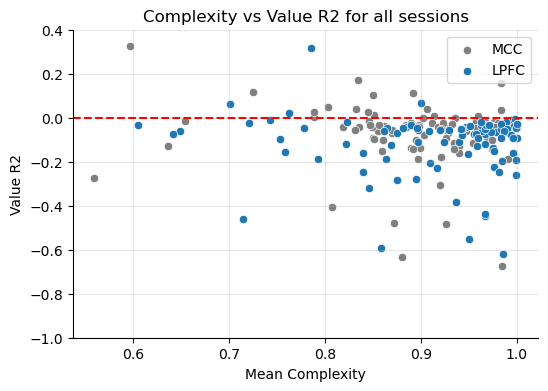

In [9]:
# plot scores against value for value > 0
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

colors = {'MCC': 'grey', 'LPFC': 'tab:blue'}
for area in ['MCC', 'LPFC']:    
    # with markers being filled circles
    sns.scatterplot(x=f'mean_complexity_{area.lower()}', y=f'value_r2_{area}', data=res, label=area, ax=ax, marker='o', color=colors[area])

ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel('Mean Complexity')
ax.set_ylabel('Value R2')

ax.set_ylim(-1, .4)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(alpha=0.3)
ax.set_title('Complexity vs Value R2 for all sessions')

---
# Section 2: Fluctuations of Dimensionality

In [10]:
example_monkey, example_session = 'ka', '030322'

# load data
neural_data = load_data_custom(example_monkey, example_session, user_msg=False)

# get dimensionality, complexity and cv
dims = measure_dimensionality(neural_data, wil_len=40, skip_len=1)


(<Axes: xlabel='Trial', ylabel='Complexity'>,
  <matplotlib.lines.Line2D at 0x3c1358130>])

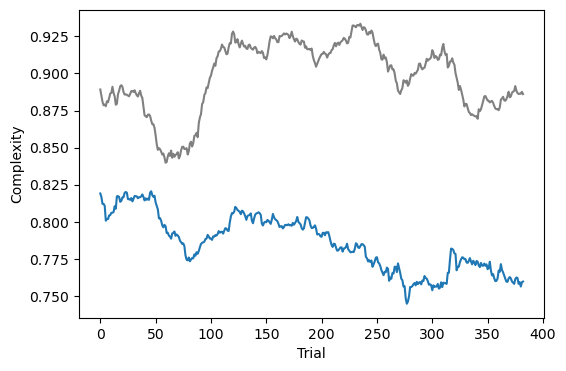

In [11]:
plot_dimensionality(dims)

## Autocorrelation of complexity (or dimensionality)

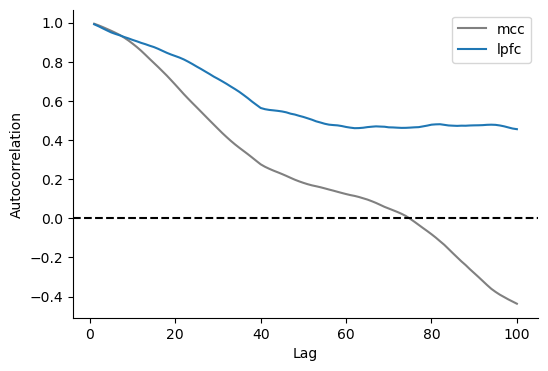

In [12]:
def get_autocorr(data, lags=50):
    autocorr = []
    for lag in range(1, lags+1):
        autocorr.append(np.corrcoef(data[:-lag], data[lag:])[0, 1])
    return autocorr

def plot_auto_correlation(dims):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    # plot residuals
    lags = 100
    for area in ['mcc', 'lpfc']:
        data = dims[f'complexity_{area}']
        autocorr = get_autocorr(data, lags=lags)
        ax.plot(np.arange(1, lags+1), autocorr, label=area, color=colors[area.upper()])

    ax.axhline(0, color='black', linestyle='--')

    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.legend()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plot_auto_correlation(dims)

---
# Section 3: Neural value function residuals

Matteo idea: *Can we consider only those sessions where the value is represented in neural activity. Then I would compare the dimensionality over time with the residuals (or better absolute value of the residual) but with sliding windows of 40 (block) as in dimensionality. Session 210322 seems to have something… Do you think that dimensionality could be somehow related to the representation of value (i.e. how much residuals deviate from 0) ?*

**Could we explain the fluctuations in dimensionality by the neural value function residuals?**  
*For example, maybe when the neural value fails to predict the behavior, the dimensionality changes?*

In [13]:
import pickle
dir = '/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/data/results'
fname = f'{example_monkey}_{example_session}_residuals.pkl'
with open(os.path.join(dir, fname), 'rb') as f:
    residuals = pickle.load(f)

residuals

,trial_id,behavioral_value,neural_value,residuals,monkey,session
0,5,0.498480,2.358648,2.153272,ka,030322
1,6,0.997308,-0.101195,-0.512091,ka,030322
2,7,-0.337252,-1.289356,-1.150407,ka,030322
3,8,0.532414,-0.517592,-0.736949,ka,030322
4,9,0.930321,0.405101,0.021804,ka,030322
...,...,...,...,...,...,...
412,417,0.532414,1.171256,0.951898,ka,030322
413,418,-0.681723,0.190719,0.471593,ka,030322
414,419,-1.357114,-1.520201,-0.961062,ka,030322
415,420,-0.120771,-1.301653,-1.251895,ka,030322


In [14]:
# 40 trial rolling window for residuals
new_residuals = []
for i in range(0, len(residuals)-40, 1):    
    res = residuals[i:i+40]
    mean_residuals = res['residuals'].values.mean()
    
    new_residuals.append({'start_trial': residuals['trial_id'].values[i], 'residuals': mean_residuals})

# add column to dims
new_residuals = pd.DataFrame(new_residuals)
new_residuals    

,start_trial,residuals
0,5,0.280339
1,6,0.243161
2,7,0.277333
3,8,0.312486
4,9,0.361141
...,...,...
372,377,-0.151708
373,378,-0.107646
374,379,-0.149997
375,380,-0.151800


In [15]:
dims = dims.merge(new_residuals, on='start_trial', how='left')
dims

,start_trial,dim_mcc,dim_lpfc,complexity_mcc,complexity_lpfc,cv_mcc,cv_lpfc,residuals
0,0.0,7.113441,21.295869,0.889180,0.819072,"[0.8844691575127324, 1.2343562147924214, 0.851...","[1.5170820175358926, 1.7836656612277746, 2.228...",NaN
1,1.0,7.081658,21.235709,0.885207,0.816758,"[0.8968945863236117, 1.2576811891251194, 0.833...","[1.4643595333022799, 1.7603216595828475, nan, ...",NaN
2,2.0,7.047173,21.113721,0.880897,0.812066,"[0.8868554389761898, 1.2777993934265308, 0.831...","[1.4592602452956767, 1.7623844296768836, nan, ...",NaN
3,3.0,7.028218,21.111967,0.878527,0.811999,"[0.8779241405635433, 1.2678528807261586, 0.830...","[1.4655905997899887, 1.8059839723490407, nan, ...",NaN
4,4.0,7.032106,21.079308,0.879013,0.810743,"[0.8736761830547413, 1.2619555216896678, 0.819...","[1.456060281030044, 1.8140634494943857, nan, 1...",NaN
...,...,...,...,...,...,...,...,...
378,378.0,7.088777,19.712267,0.886097,0.758164,"[0.8648727689832474, 1.0663909835056833, 0.894...","[1.6485442351101702, 1.791454469294795, 1.8578...",-0.107646
379,379.0,7.090894,19.740387,0.886362,0.759246,"[0.863133328839898, 1.0590786055060093, 0.8930...","[1.6469032670094839, 1.7960515317701755, 1.879...",-0.149997
380,380.0,7.090502,19.664077,0.886313,0.756311,"[0.8655266723351073, 1.0638006579781838, 0.906...","[1.6469833061135852, 1.798473840805888, 1.8780...",-0.151800
381,381.0,7.100776,19.739849,0.887597,0.759225,"[0.8651537911465335, 1.049169364223873, 0.9065...","[1.6331159187471282, 1.7900913096828313, 1.886...",-0.167968


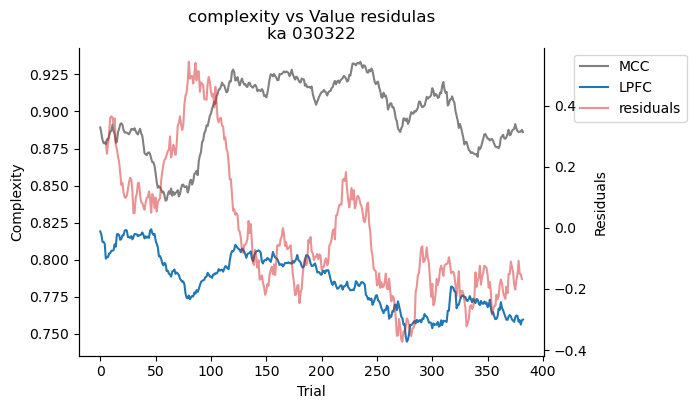

In [16]:
title = f'complexity vs Value residulas\n{example_monkey} {example_session}'
plot_dimensionality_with_dims(dims, title=title)

Text(0.5, 1.0, 'Complexity vs Residuals\nka 030322')

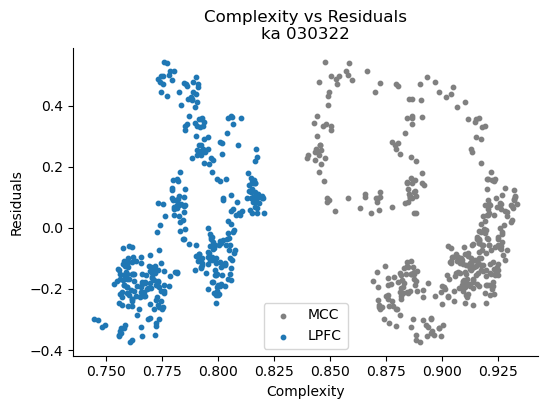

In [17]:
# correlation between residuals and value r2
residuals = dims['residuals'].values
complexity_mcc = dims['complexity_mcc'].values
complexity_lpfc = dims['complexity_lpfc'].values

# plot residuals vs complexity
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(complexity_mcc, residuals, label='MCC', color='grey', s=10)
ax.scatter(complexity_lpfc, residuals, label='LPFC', color='tab:blue', s=10)

ax.set_xlabel('Complexity')
ax.set_ylabel('Residuals')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title(f'Complexity vs Residuals\n{example_monkey} {example_session}')

